### Visualizations

## 1. Libraries

In [157]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
import pydot
import graphviz

## 2. Data Preprocessing (scraped from Hemnet)

In [158]:
df_sold = pd.read_csv('hemnet_sold_listings.csv')
df_listings = pd.read_csv('hemnet_listings.csv')

In [159]:
df_sold = df_sold.dropna()
df_listings = df_listings.drop(columns=['latitude', 'longitude'])
df_listings = df_listings.dropna()

In [160]:
print(df_sold.shape)
df_sold.head()

(2241, 13)


,link,exact_address,size,rooms,monthly_fee,location,has_elevator,has_balcony,listing_price,end_price,price_change_percentage,price_per_sqm,date
0,https://www.hemnet.se/salda/lagenhet-2rum-skar...,Pilotgatan 8,65.0,2.0,5004,"Skarpnäck, Stockholms kommun",False,False,2000000,2500000,25,38462.0,2024-09-17
1,"https://www.hemnet.se/salda/lagenhet-4,5rum-ne...",Starrängsringen 44,107.0,4.5,3559,"Nedre Gärdet - Östermalm, Stockholms kommun",True,True,11548672,13050000,13,121963.0,2024-09-16
2,https://www.hemnet.se/salda/lagenhet-3rum-vall...,Skattegårdsvägen 65,78.0,3.0,5576,"Vällingby Centrum, Stockholms kommun",True,False,2884615,3000000,4,38462.0,2024-09-16
4,https://www.hemnet.se/salda/lagenhet-3rum-sode...,Maria prästgårdsgata 43,68.0,3.0,3825,"Södermalm, Stockholms kommun",False,True,6476190,6800000,5,100000.0,2024-09-16
6,https://www.hemnet.se/salda/lagenhet-5rum-norr...,Älvkarleövägen 33,117.0,5.0,5988,"Norra Djurgårdsstaden, Stockholms kommun",True,True,13431372,13700000,2,117094.0,2024-09-16


In [161]:
print(df_listings.shape)
df_listings.head()

(2430, 11)


,link,exact_address,price,size,rooms,floor,monthly_fee,price_per_sqm,location,has_elevator,has_balcony
0,https://www.hemnet.se/bostad/lagenhet-4rum-vas...,Gävlegatan 4,10500000,96.0,4.0,3,4561.0,109375.0,"Vasastan, Stockholms kommun",True,True
1,"https://www.hemnet.se/bostad/lagenhet-1,5rum-g...",Östhammarsgatan 70B,3250000,35.0,1.5,2,2610.0,92857.0,"Gärdet - Östermalm, Stockholms kommun",True,True
3,https://www.hemnet.se/bostad/lagenhet-3rum-mar...,Masugnsvägen 86,5795000,79.5,3.0,3,4797.0,72893.0,"Mariehäll, Stockholms kommun",True,True
4,https://www.hemnet.se/bostad/lagenhet-2rum-spa...,Åkare Engströms Väg 5,2150000,43.0,2.0,3,2662.0,50000.0,"Spånga - Bromstensstaden, Stockholms kommun",True,False
5,https://www.hemnet.se/bostad/lagenhet-3rum-gar...,Sandhamnsgatan 75B,7395000,82.0,3.0,1,6186.0,90183.0,"Gärdet, Stockholms kommun",True,False


## 3. Exploratory Data Analysis (EDA)

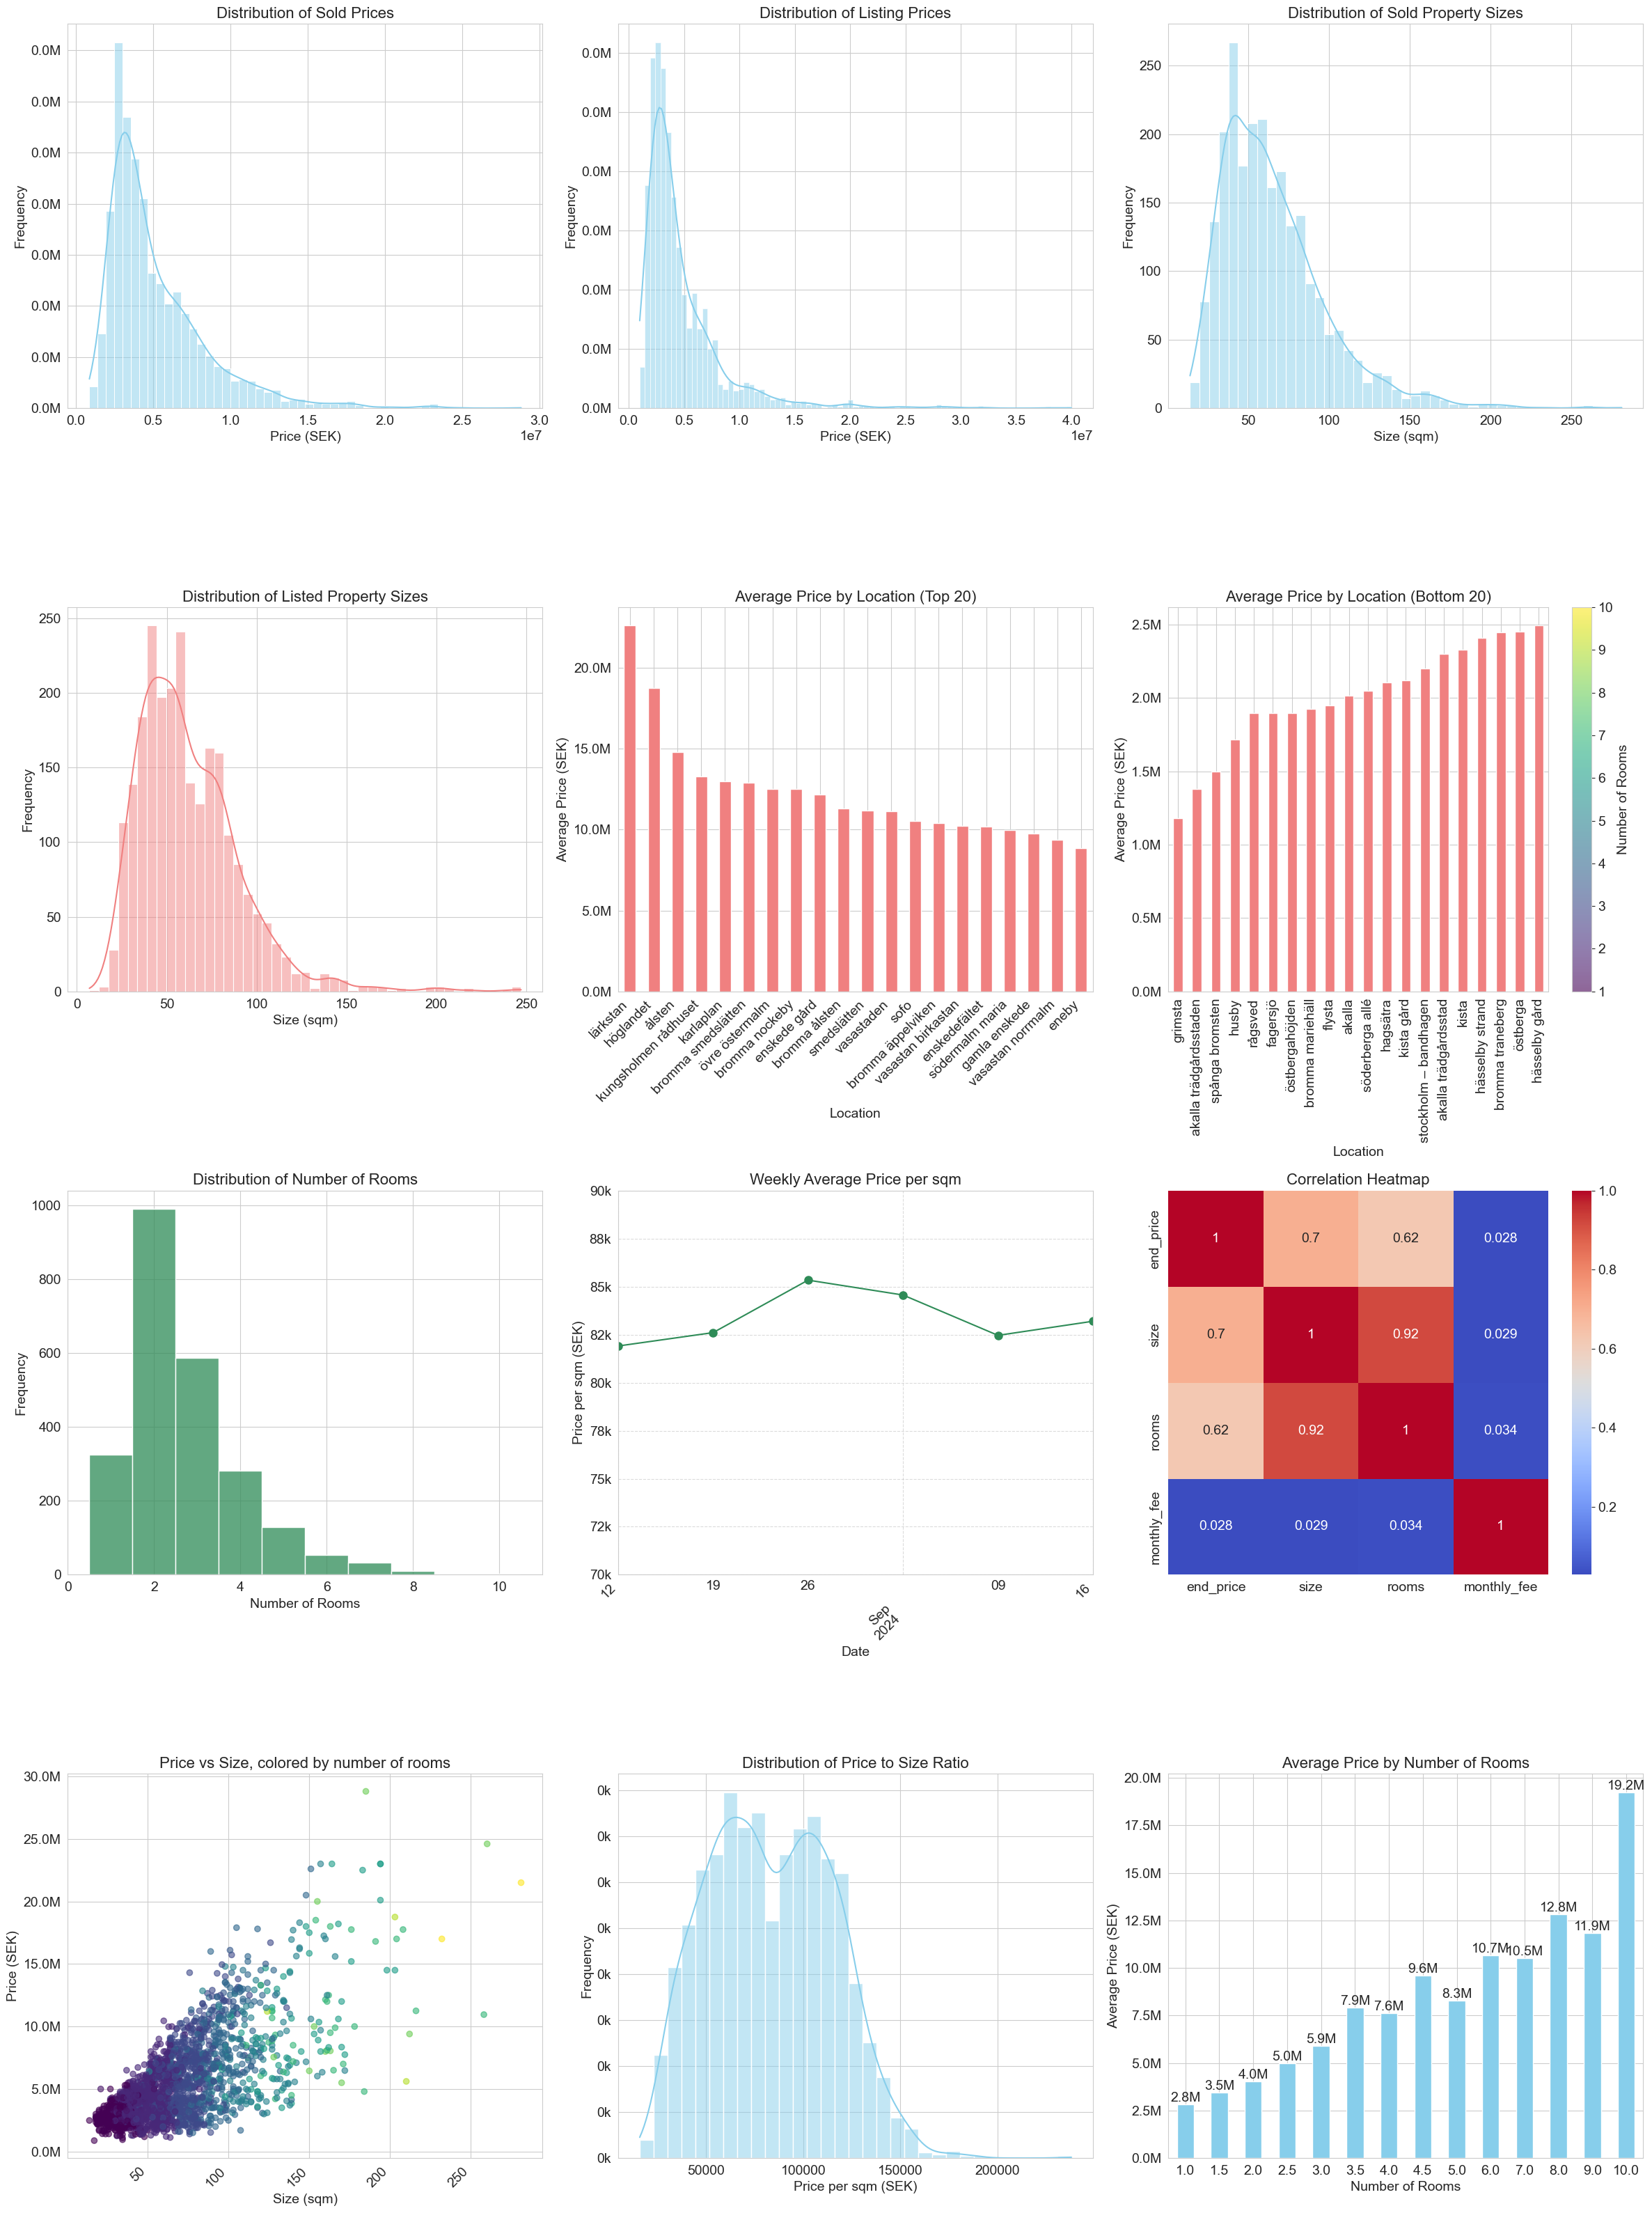


Key Insights:
1. The average sold price is 5,237,014.17 SEK
2. The most expensive area is lärkstan with an average price of 22,600,000.00 SEK
3. The least expensive area is grimsta with an average price of 1,180,000.00 SEK
4. The correlation between size and price is 0.70
5. The average price per square meter is 83,177.25 SEK
6. The median size of sold properties is 59.00 sqm
7. The most common number of rooms in sold properties is 2.0
8. The correlation between monthly fee and price is 0.03
9. The data covers the period from 2024-08-12 to 2024-09-16
10. Over this period, the weekly average price per sqm increased by 1.57%
11. The weekly average price per square meter ranges from 81,909 SEK to 85,338 SEK
12. The average price for a 1-room property is 2,820,073.85 SEK, while a 5-room property averages 8,285,247.93 SEK


In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Load the datasets
df_listings = pd.read_csv('hemnet_listings.csv')
df_sold = pd.read_csv('hemnet_sold_listings.csv')

def parse_location_enhanced(location_str):
    if isinstance(location_str, str):
        location_str = location_str.strip().lower()
        location_str = re.sub(r',?\s*stockholms kommun', '', location_str)
        split_regex = r'[-/|]'
        parts = re.split(split_regex, location_str)
        main_neighborhood = parts[0].strip()
        return main_neighborhood
    else:
        return 'unknown'

# Apply the new parsing function
for df in [df_sold, df_listings]:
    df['main_neighborhood'] = df['location'].apply(parse_location_enhanced)

# Function to format y-axis labels in millions
def millions_formatter(x, pos):
    return f'{x/1e6:.1f}M'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Set a consistent style for all plots
#plt.style.use('seaborn-whitegrid')
sns.set_palette("deep")
# Apply a consistent style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})

# Create a 3x3 grid of subplots with better aesthetics
# Create a 4x3 grid of subplots with better aesthetics
fig, axes = plt.subplots(4, 3, figsize=(24, 32))

# Function to format y-axis labels in millions
def millions_formatter(x, pos):
    return f'{x/1e6:.1f}M'

# Function to format y-axis labels in thousands
def thousands_formatter(x, pos):
    return f'{x/1e3:.0f}k'

# 1. Distribution of Sold Prices
sns.histplot(df_sold['end_price'], kde=True, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Sold Prices', fontsize=16)
axes[0, 0].set_xlabel('Price (SEK)', fontsize=14)
axes[0, 0].set_ylabel('Frequency', fontsize=14)
axes[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[0, 0].grid(True)

# 2. Distribution of Listing Prices
sns.histplot(df_listings['price'], kde=True, color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Listing Prices', fontsize=16)
axes[0, 1].set_xlabel('Price (SEK)', fontsize=14)
axes[0, 1].set_ylabel('Frequency', fontsize=14)
axes[0, 1].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[0, 1].grid(True)

# 3. Distribution of Sold Property Sizes
sns.histplot(df_sold['size'], kde=True, color='skyblue', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Sold Property Sizes', fontsize=16)
axes[0, 2].set_xlabel('Size (sqm)', fontsize=14)
axes[0, 2].set_ylabel('Frequency', fontsize=14)
axes[0, 2].grid(True)

# 4. Distribution of Listed Property Sizes
sns.histplot(df_listings['size'], kde=True, color='lightcoral', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Listed Property Sizes', fontsize=16)
axes[1, 0].set_xlabel('Size (sqm)', fontsize=14)
axes[1, 0].set_ylabel('Frequency', fontsize=14)
axes[1, 0].grid(True)

# 5. Top 20 locations by average price
location_avg_price_top.plot(kind='bar', color='lightcoral', ax=axes[1, 1])
axes[1, 1].set_title('Average Price by Location (Top 20)', fontsize=16)
axes[1, 1].set_xlabel('Location', fontsize=14)
axes[1, 1].set_ylabel('Average Price (SEK)', fontsize=14)
axes[1, 1].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[1, 1].grid(True)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')


# 6. Bottom 20 locations by average price (New plot)
location_avg_price_bottom = df_sold.groupby('main_neighborhood')['end_price'].mean().sort_values().head(20)
location_avg_price_bottom.plot(kind='bar', color='lightcoral', ax=axes[1, 2])
axes[1, 2].set_title('Average Price by Location (Bottom 20)', fontsize=16)
axes[1, 2].set_xlabel('Location', fontsize=14)
axes[1, 2].set_ylabel('Average Price (SEK)', fontsize=14)
axes[1, 2].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[1, 2].grid(True)
plt.setp(axes[3, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')


# 7. Distribution of Number of Rooms
sns.histplot(df_sold['rooms'], kde=False, color='seagreen', ax=axes[2, 0], discrete=True)
axes[2, 0].set_title('Distribution of Number of Rooms', fontsize=16)
axes[2, 0].set_xlabel('Number of Rooms', fontsize=14)
axes[2, 0].set_ylabel('Frequency', fontsize=14)
axes[2, 0].grid(True)

# 8. Weekly Average Price per sqm
weekly_avg_price.plot(ax=axes[2, 1], marker='o', linestyle='-', color='seagreen', markersize=8)
axes[2, 1].set_title('Weekly Average Price per sqm', fontsize=16)
axes[2, 1].set_xlabel('Date', fontsize=14)
axes[2, 1].set_ylabel('Price per sqm (SEK)', fontsize=14)
axes[2, 1].yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
axes[2, 1].grid(True, linestyle='--', alpha=0.7)
axes[2, 1].set_ylim([70000, 90000])
plt.setp(axes[2, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 9. Correlation Heatmap
corr_matrix = df_sold[['end_price', 'size', 'rooms', 'monthly_fee']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[2, 2])
axes[2, 2].set_title('Correlation Heatmap', fontsize=16)

# 10. Feature Relationships: Price vs Size, colored by number of rooms
scatter = axes[3, 0].scatter(df_sold['size'], df_sold['end_price'], c=df_sold['rooms'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, ax=axes[1, 2], label='Number of Rooms')
axes[3, 0].set_title('Price vs Size, colored by number of rooms', fontsize=16)
axes[3, 0].set_xlabel('Size (sqm)', fontsize=14)
axes[3, 0].set_ylabel('Price (SEK)', fontsize=14)
axes[3, 0].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[3, 0].grid(True)

# 11. Price to Size Ratio Distribution
df_sold['price_to_size_ratio'] = df_sold['end_price'] / df_sold['size']
sns.histplot(df_sold['price_to_size_ratio'], kde=True, color='skyblue', ax=axes[3, 1])
axes[3, 1].set_title('Distribution of Price to Size Ratio', fontsize=16)
axes[3, 1].set_xlabel('Price per sqm (SEK)', fontsize=14)
axes[3, 1].set_ylabel('Frequency', fontsize=14)
axes[3, 1].yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))
axes[3, 1].grid(True)

# 12. Monthly Fee vs Price
# 12. Average Price Trend by Number of Rooms
room_price_avg = df_sold.groupby('rooms')['end_price'].mean().sort_index()
room_price_avg.plot(kind='bar', ax=axes[3, 2], color='skyblue')
axes[3, 2].set_title('Average Price by Number of Rooms', fontsize=16)
axes[3, 2].set_xlabel('Number of Rooms', fontsize=14)
axes[3, 2].set_ylabel('Average Price (SEK)', fontsize=14)
axes[3, 2].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axes[3, 2].grid(True, axis='y')

# Add value labels on top of each bar
for i, v in enumerate(room_price_avg):
    axes[3, 2].text(i, v, f'{v/1e6:.1f}M', ha='center', va='bottom')

plt.setp(axes[3, 2].xaxis.get_majorticklabels(), rotation=0)  # Ensure x-labels are not rotated


plt.tight_layout()
plt.show()

# Print key insights (you can add more based on the new plots)
print("\nKey Insights:")
print(f"1. The average sold price is {df_sold['end_price'].mean():,.2f} SEK")
print(f"2. The most expensive area is {location_avg_price_top.index[0]} with an average price of {location_avg_price_top.iloc[0]:,.2f} SEK")
print(f"3. The least expensive area is {location_avg_price_bottom.index[0]} with an average price of {location_avg_price_bottom.iloc[0]:,.2f} SEK")
print(f"4. The correlation between size and price is {df_sold['size'].corr(df_sold['end_price']):.2f}")
print(f"5. The average price per square meter is {df_sold['price_to_size_ratio'].mean():,.2f} SEK")
print(f"6. The median size of sold properties is {df_sold['size'].median():.2f} sqm")
print(f"7. The most common number of rooms in sold properties is {df_sold['rooms'].mode().values[0]}")
print(f"8. The correlation between monthly fee and price is {df_sold['monthly_fee'].corr(df_sold['end_price']):.2f}")
print(f"9. The data covers the period from {weekly_avg_price.index.min().strftime('%Y-%m-%d')} to {weekly_avg_price.index.max().strftime('%Y-%m-%d')}")
price_change = (weekly_avg_price.iloc[-1] - weekly_avg_price.iloc[0]) / weekly_avg_price.iloc[0] * 100
print(f"10. Over this period, the weekly average price per sqm {'increased' if price_change > 0 else 'decreased'} by {abs(price_change):.2f}%")
print(f"11. The weekly average price per square meter ranges from {weekly_avg_price.min():,.0f} SEK to {weekly_avg_price.max():,.0f} SEK")
# Update the relevant key insight
print(f"12. The average price for a 1-room property is {room_price_avg[1]:,.2f} SEK, while a 5-room property averages {room_price_avg[5]:,.2f} SEK")


## 4. Feature Engineering

In [182]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample

# ===========================
# 1. Load Datasets
# ===========================

df_listings = pd.read_csv('hemnet_listings.csv')
df_sold = pd.read_csv('hemnet_sold_listings.csv')

# ===========================
# 2. Data Cleaning and Preprocessing
# ===========================

def clean_data(df, price_column='price'):
    df = df.dropna(subset=['exact_address', price_column, 'size'])
    df = df[df['exact_address'].str.strip() != '']
    return df

df_sold['price'] = df_sold['end_price']
df_listings = df_listings.rename(columns={'price': 'listing_price'})

df_sold = clean_data(df_sold, price_column='price')
df_listings = clean_data(df_listings, price_column='listing_price')

# ===========================
# 3. Generate Random Dates for Listings
# ===========================

current_date = datetime.now()
one_month_ago = current_date - timedelta(days=30)
df_listings['date'] = pd.to_datetime([
    one_month_ago + timedelta(days=np.random.randint(0, 31)) for _ in range(len(df_listings))
])

# ===========================
# 4. Parse Location
# ===========================

def parse_location_enhanced(location_str):
    if isinstance(location_str, str):
        location_str = location_str.strip().lower()
        location_str = re.sub(r',?\s*stockholms kommun', '', location_str)
        split_regex = r'[-/|]'
        parts = re.split(split_regex, location_str)
        main_neighborhood = parts[0].strip()
        return main_neighborhood
    else:
        return 'unknown'

# Apply the new parsing function
for df in [df_sold, df_listings]:
    df['main_neighborhood'] = df['location'].apply(parse_location_enhanced)

df_sold['date'] = pd.to_datetime(df_sold['date'])

# ===========================
# 5. Feature Engineering
# ===========================

def feature_engineering(df, price_col='listing_price'):
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['main_neighborhood', 'date'])

    window = 90
    df[f'roll_price_{window}d'] = df.groupby('main_neighborhood')[price_col].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    df[f'roll_size_{window}d'] = df.groupby('main_neighborhood')['size'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )
    df[f'roll_avg_price_per_sqm_{window}d'] = df[f'roll_price_{window}d'] / df[f'roll_size_{window}d']

    df = df.drop(columns=[f'roll_price_{window}d', f'roll_size_{window}d'])
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['season'] = df['date'].dt.month % 12 // 3 + 1
    df['rooms_per_sqm'] = df['rooms'] / df['size']
    df['is_central'] = df['location'].str.contains('centrum|centrala|city', case=False, na=False).astype(int)
    df['price_per_sqm'] = df[price_col] / df['size']
    df['months_since_sale'] = (datetime.now() - df['date']).dt.days / 30.44

    for col in ['size', 'price_per_sqm', 'monthly_fee']:
        if col in df.columns and (df[col] > 0).all():
            df[f'log_{col}'] = np.log1p(df[col])
        else:
            df[f'log_{col}'] = 0
    
    return df

df_sold = feature_engineering(df_sold, price_col='price')
df_listings = feature_engineering(df_listings, price_col='listing_price')

# ===========================
# 6. Calculate Average Prices
# ===========================

def calculate_average_prices(df_sold, df_listings):
    location_avg_price = df_sold.groupby('main_neighborhood')['price_per_sqm'].mean()
    df_sold['location_avg_price_per_sqm'] = df_sold['main_neighborhood'].map(location_avg_price)
    df_listings['location_avg_price_per_sqm'] = df_listings['main_neighborhood'].map(location_avg_price)

    return df_sold, df_listings

df_sold, df_listings = calculate_average_prices(df_sold, df_listings)

# ===========================
# 7. Handle Outliers
# ===========================

def remove_outliers(df, n_std=4):
    columns = ['size', 'rooms', 'monthly_fee', 'price_per_sqm', 'price']
    for col in columns:
        if col in df.columns:
            mean = df[col].mean()
            std = df[col].std()
            lower_bound = mean - n_std * std
            upper_bound = mean + n_std * std
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_sold = remove_outliers(df_sold)
df_listings = remove_outliers(df_listings)

# ===========================
# 8. Define Features
# ===========================

# Update the features list
features = [
    'size', 'rooms', 'monthly_fee', 'has_elevator', 'has_balcony',
    'listing_price', 'rooms_per_sqm', 'is_central', 'year', 'month', 'season',
    'main_neighborhood', 'months_since_sale',
    'price_per_sqm', 'log_size', 'log_price_per_sqm', 'log_monthly_fee',
    'roll_avg_price_per_sqm_90d', 'location_avg_price_per_sqm',
]

numeric_features = [
    'size', 'rooms', 'monthly_fee', 'listing_price',
    'rooms_per_sqm', 'price_per_sqm', 'months_since_sale',
    'log_size', 'log_price_per_sqm', 'log_monthly_fee',
    'roll_avg_price_per_sqm_90d', 'location_avg_price_per_sqm',
]

categorical_features = [
    'has_elevator', 'has_balcony', 'is_central', 
    'main_neighborhood', 
    'month', 'season'
]

## 5. Model Selection

In [202]:
# ===========================
# 9. Prepare Data for Training
# ===========================

# Features and target
X = df_sold[features]
y = df_sold['price']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check the sizes to ensure you've tripled the dataset
print("Original training size:", X_train.shape)

# Check the sizes to ensure you've tripled the dataset
print("Original training size:", X_train.shape)

# ===========================
# 10. Create the Preprocessor
# ===========================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', RobustScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)

print("Number of features after preprocessing:", X_train_preprocessed.shape[1])

# ===========================
# 11. Scale the Target Variable
# ===========================

y_scaler = RobustScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = y_scaler.transform(y_val.values.reshape(-1, 1)).flatten()

# ===========================
# 12. Create the Neural Network Model
# ===========================

# Calculate the 5th percentile of the listing prices
price_threshold = np.percentile(df_sold['price'], 5)
price_threshold = np.percentile(df_sold['price'], 5)
low_size_threshold = np.percentile(df_sold['size'], 2.5)

def custom_weighted_loss(y_true, y_pred, low_price_threshold, high_price_threshold):
    # Calculate the residuals
    residual = K.abs(y_true - y_pred)
    
    # Define weights based on price thresholds
    low_size_weight = K.cast(y_true <= low_size_threshold, 'float32') * 2  # 50% more weight for low prices
    low_price_weight = K.cast(y_true <= low_price_threshold, 'float32') * 2  # 50% more weight for low prices
    high_price_weight = K.cast(y_true >= high_price_threshold, 'float32') * 1.2  # 50% more weight for high prices
    
    # No extra weight for mid-range prices
    normal_weight = K.cast((y_true > low_price_threshold) & (y_true < high_price_threshold) & (y_true > low_size_weight), 'float32')
    
    # Combine weights
    weights = low_price_weight + high_price_weight + low_size_weight + normal_weight 
    
    # Apply weights to the residuals
    weighted_loss = residual * weights
    
    return K.mean(weighted_loss)

def enhanced_weighted_loss(y_true, y_pred):
    median_price = K.median(y_true)
    price_deviation = K.abs(y_true - median_price)
    
    # Define weight as a factor of the deviation from the median price
    # For example, 1x for close to median, up to 2x for large deviations
    weight = 1 + (price_deviation / median_price) * 1.50
    
    residual = K.abs(y_true - y_pred)
    weighted_loss = residual * weight
    
    return K.mean(weighted_loss)

low_size_weight = 25
low_price_threshold = 2000000
high_price_threshold = 12000000

def create_model(input_dim, l2_lambda=0.01):
    main_input = Input(shape=(input_dim,), name='main_input')
    listing_price_input = Input(shape=(1,), name='listing_price_input')
    
    # Define the dense layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda))(main_input)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda))(x)
    x = BatchNormalization()(x)
    
    # Concatenate listing price input
    combined = Concatenate()([x, listing_price_input])
    
    # Output layer
    output = Dense(16, activation='relu', kernel_regularizer=l2(l2_lambda))(combined)
    final_output = Dense(1, kernel_regularizer=l2(l2_lambda))(output)
    
    # Create and compile the model without any bias adjustment
    model = Model(inputs=[main_input, listing_price_input], outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=lambda y_true, y_pred: custom_weighted_loss(y_true, y_pred, low_price_threshold, high_price_threshold))
    
    return model


# ===========================
# 13. Prepare Data for the New Model Architecture
# ===========================

listing_price_index = features.index('listing_price')

X_train_main = np.delete(X_train_preprocessed, listing_price_index, axis=1)
X_train_listing_price = X_train_preprocessed[:, listing_price_index].reshape(-1, 1)

X_val_main = np.delete(X_val_preprocessed, listing_price_index, axis=1)
X_val_listing_price = X_val_preprocessed[:, listing_price_index].reshape(-1, 1)


Original training size: (1899, 19)
Original training size: (1899, 19)
Number of features after preprocessing: 218


## 7. Model Training

/Users/adamthuvesen/.pyenv/versions/3.9.18/envs/py39/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     model.compile(optimizer=Adam(learning_rate=0.001), loss=lambda y_true, y_pred: custom_weighted_loss(y_true, y_pred, low_price_threshold, high_price_threshold))

  return {key: serialize_keras_object(value) for key, value in obj.items()}



Epoch 162: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 246: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 297: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 383: early stopping
Restoring model weights from the end of the best epoch: 333.

Final Training Loss: 0.2179
Final Validation Loss: 0.1747


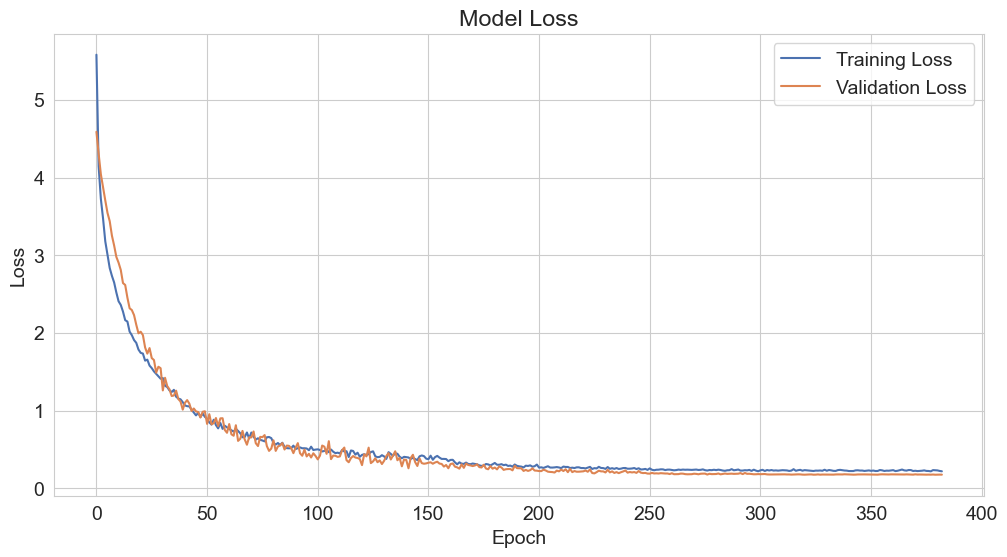

Loss history saved to 'model_loss_history.csv'


In [204]:
# ===========================
# 14. Create and Train the Model
# ===========================

n_features = X_train_main.shape[1]
nn_model = create_model(n_features, l2_lambda=0.01)

early_stopping = EarlyStopping(patience=50, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=20, min_lr=0.00001, verbose=1)

history = nn_model.fit(
    [X_train_main, X_train_listing_price], y_train_scaled,
    validation_data=([X_val_main, X_val_listing_price], y_val_scaled),
    epochs=500,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback],
    verbose=0
)

# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Print final loss values
print(f"\nFinal Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Save loss values to CSV
loss_df = pd.DataFrame({
    'epoch': range(1, len(train_loss) + 1),
    'train_loss': train_loss,
    'val_loss': val_loss
})
loss_df.to_csv('model_loss_history.csv', index=False)
print("Loss history saved to 'model_loss_history.csv'")


## 8. Model Evaluation

In [205]:
# ===========================
# 15. Evaluate the Model
# ===========================

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    price_delta = (y_pred - y_true) / y_true * 100
    avg_price_delta = np.mean(price_delta)
    median_price_delta = np.median(price_delta)
    
    print(f"\n{model_name} Performance:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared Score: {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
    print(f"Average Price Delta: {avg_price_delta:.2f}%")
    print(f"Median Price Delta: {median_price_delta:.2f}%")
    
    print("\nPrediction error on evaluation set:")
    print(pd.Series(price_delta).describe())

# Make predictions on validation set
y_val_pred_scaled = nn_model.predict([X_val_main, X_val_listing_price]).flatten()
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
y_val_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()

# Evaluate the model
evaluate_model(y_val_true, y_val_pred, "Neural Network (With Emphasized Listing Price)")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Neural Network (With Emphasized Listing Price) Performance:
Root Mean Squared Error (RMSE): 103111.39
R-squared Score: 0.9986
Mean Absolute Percentage Error (MAPE): 1.14%
Average Price Delta: 0.16%
Median Price Delta: 0.11%

Prediction error on evaluation set:
count    475.000000
mean       0.160042
std        1.646070
min       -7.005101
25%       -0.769274
50%        0.109127
75%        0.864164
max        8.533968
dtype: float64


## 9. Predict Listings

In [206]:
# ===========================
# 17. Make Predictions for real Listings
# ===========================

X_listings_preprocessed = preprocessor.transform(df_listings[features])
X_listings_main = np.delete(X_listings_preprocessed, listing_price_index, axis=1)
X_listings_listing_price = X_listings_preprocessed[:, listing_price_index].reshape(-1, 1)

listings_pred_scaled = nn_model.predict([X_listings_main, X_listings_listing_price]).flatten()
listings_pred = y_scaler.inverse_transform(listings_pred_scaled.reshape(-1, 1)).flatten()

# Add predictions to df_listings
df_listings['predicted_price'] = listings_pred

# Calculate price delta
df_listings['price_delta'] = (df_listings['predicted_price'] - df_listings['listing_price']) / df_listings['listing_price'] * 100

# ===========================
# 18. Analyze Predictions
# ===========================

print("\nPrice Delta Summary Statistics for All Listings on Test Set:")
print(df_listings['price_delta'].describe())

# Handle infinite values by removing them from the calculation
mape_listings = np.mean(np.abs(df_listings['price_delta'].replace([np.inf, -np.inf], np.nan).dropna()))
print(f"\nMean Absolute Percentage Error (MAPE) for All Listings Predictions: {mape_listings:.2f}%")

# ===========================
# 20. Identify Potential Deals
# ===========================

# Sort by price delta to find potential undervalued properties
potential_deals = df_listings[df_listings['price_delta'] > 0].sort_values('price_delta', ascending=False)

print("\nTop 10 Potential Deals (Undervalued Properties):")
print(potential_deals[['link', 'listing_price', 'predicted_price', 'price_delta']].head(10))

potential_deals = df_listings[df_listings['price_delta'] < 0].sort_values('price_delta', ascending=True)

print("\nTop 10 Potential Bad Deals (Overvalued Properties):")
print(potential_deals[['link', 'listing_price', 'predicted_price', 'price_delta']].head(10))

# ===========================
# 21. Save Results
# ===========================

# Save predictions to CSV
output_file = "predictions_with_emphasized_listing_price.csv"
df_listings[['listing_price', 'predicted_price', 'price_delta']].to_csv(output_file, index=False)
print(f"\nPredictions saved to {output_file}")

# ===========================
# 22. Model Summary
# ===========================

print("\nModel Summary:")
nn_model.summary()

# ===========================
# 23. Feature Importance Analysis with Diagnostics
# ===========================

print("\nDiagnostic Information:")
print(f"Total number of features: {len(features)}")
print(f"Number of numeric features: {len(numeric_features)}")
print(f"Number of categorical features: {len(categorical_features)}")


print("\nNote: 'listing_price' is not included in this analysis as it's handled separately in the model.")
print("Its importance is implicitly high due to the model architecture.")

# ===========================
# 24. Final Remarks
# ===========================

print("\nNeural Network model training and evaluation completed.")
print("The model emphasizes the listing_price feature while considering other relevant features.")
print("Predictions have been made for all listings and potential deals have been identified.")
print("Review the generated visualizations and CSV output for further insights.")

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step

Price Delta Summary Statistics for All Listings on Test Set:
count    2402.000000
mean        0.886142
std         1.844449
min       -14.349193
25%        -0.128482
50%         0.727994
75%         1.654093
max        10.483996
Name: price_delta, dtype: float64

Mean Absolute Percentage Error (MAPE) for All Listings Predictions: 1.43%

Top 10 Potential Deals (Undervalued Properties):
                                                   link  listing_price  \
671   https://www.hemnet.se/bostad/lagenhet-1rum-hog...        1195000   
2331  https://www.hemnet.se/bostad/lagenhet-6rum-lil...       13495000   
1884  https://www.hemnet.se/bostad/lagenhet-1rum-spa...        1150000   
188   https://www.hemnet.se/bostad/lagenhet-1rum-rin...         995000   
670   https://www.hemnet.se/bostad/lagenhet-1rum-hog...        1095000   
51    https://www.hemnet.se/bostad/lagenhet-1rum-bro...        1195000   
946   https://www.hemnet.se/bostad/lagenhet-1rum-kun

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 217)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 128)       │     27,904 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_26[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_27[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_67[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ listing_price_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 33)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ listing_price_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 16)        │        544 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 1)         │         17 │ dense_68[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,197 (461.71 KB)

 Trainable params: 39,249 (153.32 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 78,500 (306.64 KB)


Diagnostic Information:
Total number of features: 19
Number of numeric features: 12
Number of categorical features: 6

Note: 'listing_price' is not included in this analysis as it's handled separately in the model.
Its importance is implicitly high due to the model architecture.

Neural Network model training and evaluation completed.
The model emphasizes the listing_price feature while considering other relevant features.
Predictions have been made for all listings and potential deals have been identified.
Review the generated visualizations and CSV output for further insights.


## 10. Model Logs

In [207]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

# Assuming your model is called 'model'

# Method 1: Using plot_model
try:
    plot_model(nn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    print("Model plot saved as 'model_plot.png'")
except Exception as e:
    print(f"Error in plot_model: {e}")

# Method 2: Print model summary
print("\nModel Summary:")
nn_model.summary()

# Method 3: Custom text-based visualization
def print_model_structure(model):
    def print_layer(layer, prefix=''):
        print(f"{prefix}|-- {layer.__class__.__name__}")
        if hasattr(layer, 'layers'):
            for sublayer in layer.layers:
                print_layer(sublayer, prefix + '    ')
    
    print("Model Structure:")
    for layer in nn_model.layers:
        print_layer(layer)

print("\nCustom Model Structure:")
#print_model_structure(model)

# Method 4: Using TensorBoard
log_dir = 'logs/fit'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
print("\nTensorBoard callback created. Add this to your model.fit() call:")
print("model.fit(..., callbacks=[tensorboard_callback])")
print("Then run 'tensorboard --logdir logs/fit' in your terminal")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
Model plot saved as 'model_plot.png'

Model Summary:


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ main_input          │ (None, 217)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_65 (Dense)    │ (None, 128)       │     27,904 │ main_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ dense_65[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_26[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_27[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_67 (Dense)    │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_67[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ listing_price_input │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 33)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ listing_price_in… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 16)        │        544 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 1)         │         17 │ dense_68[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 118,197 (461.71 KB)

 Trainable params: 39,249 (153.32 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 78,500 (306.64 KB)


Custom Model Structure:

TensorBoard callback created. Add this to your model.fit() call:
model.fit(..., callbacks=[tensorboard_callback])
Then run 'tensorboard --logdir logs/fit' in your terminal


## 11. Model Predictions Visualized

/var/folders/h7/6tr60rps7rg1tsw4q4rzdnc40000gn/T/ipykernel_23781/1310512086.py:59: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_listings['listing_price'], color=colors[1], shade=True, label='Actual', ax=axs[1, 2])
/var/folders/h7/6tr60rps7rg1tsw4q4rzdnc40000gn/T/ipykernel_23781/1310512086.py:60: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_listings['predicted_price'], color='darkred', shade=True, label='Predicted', ax=axs[1, 2])


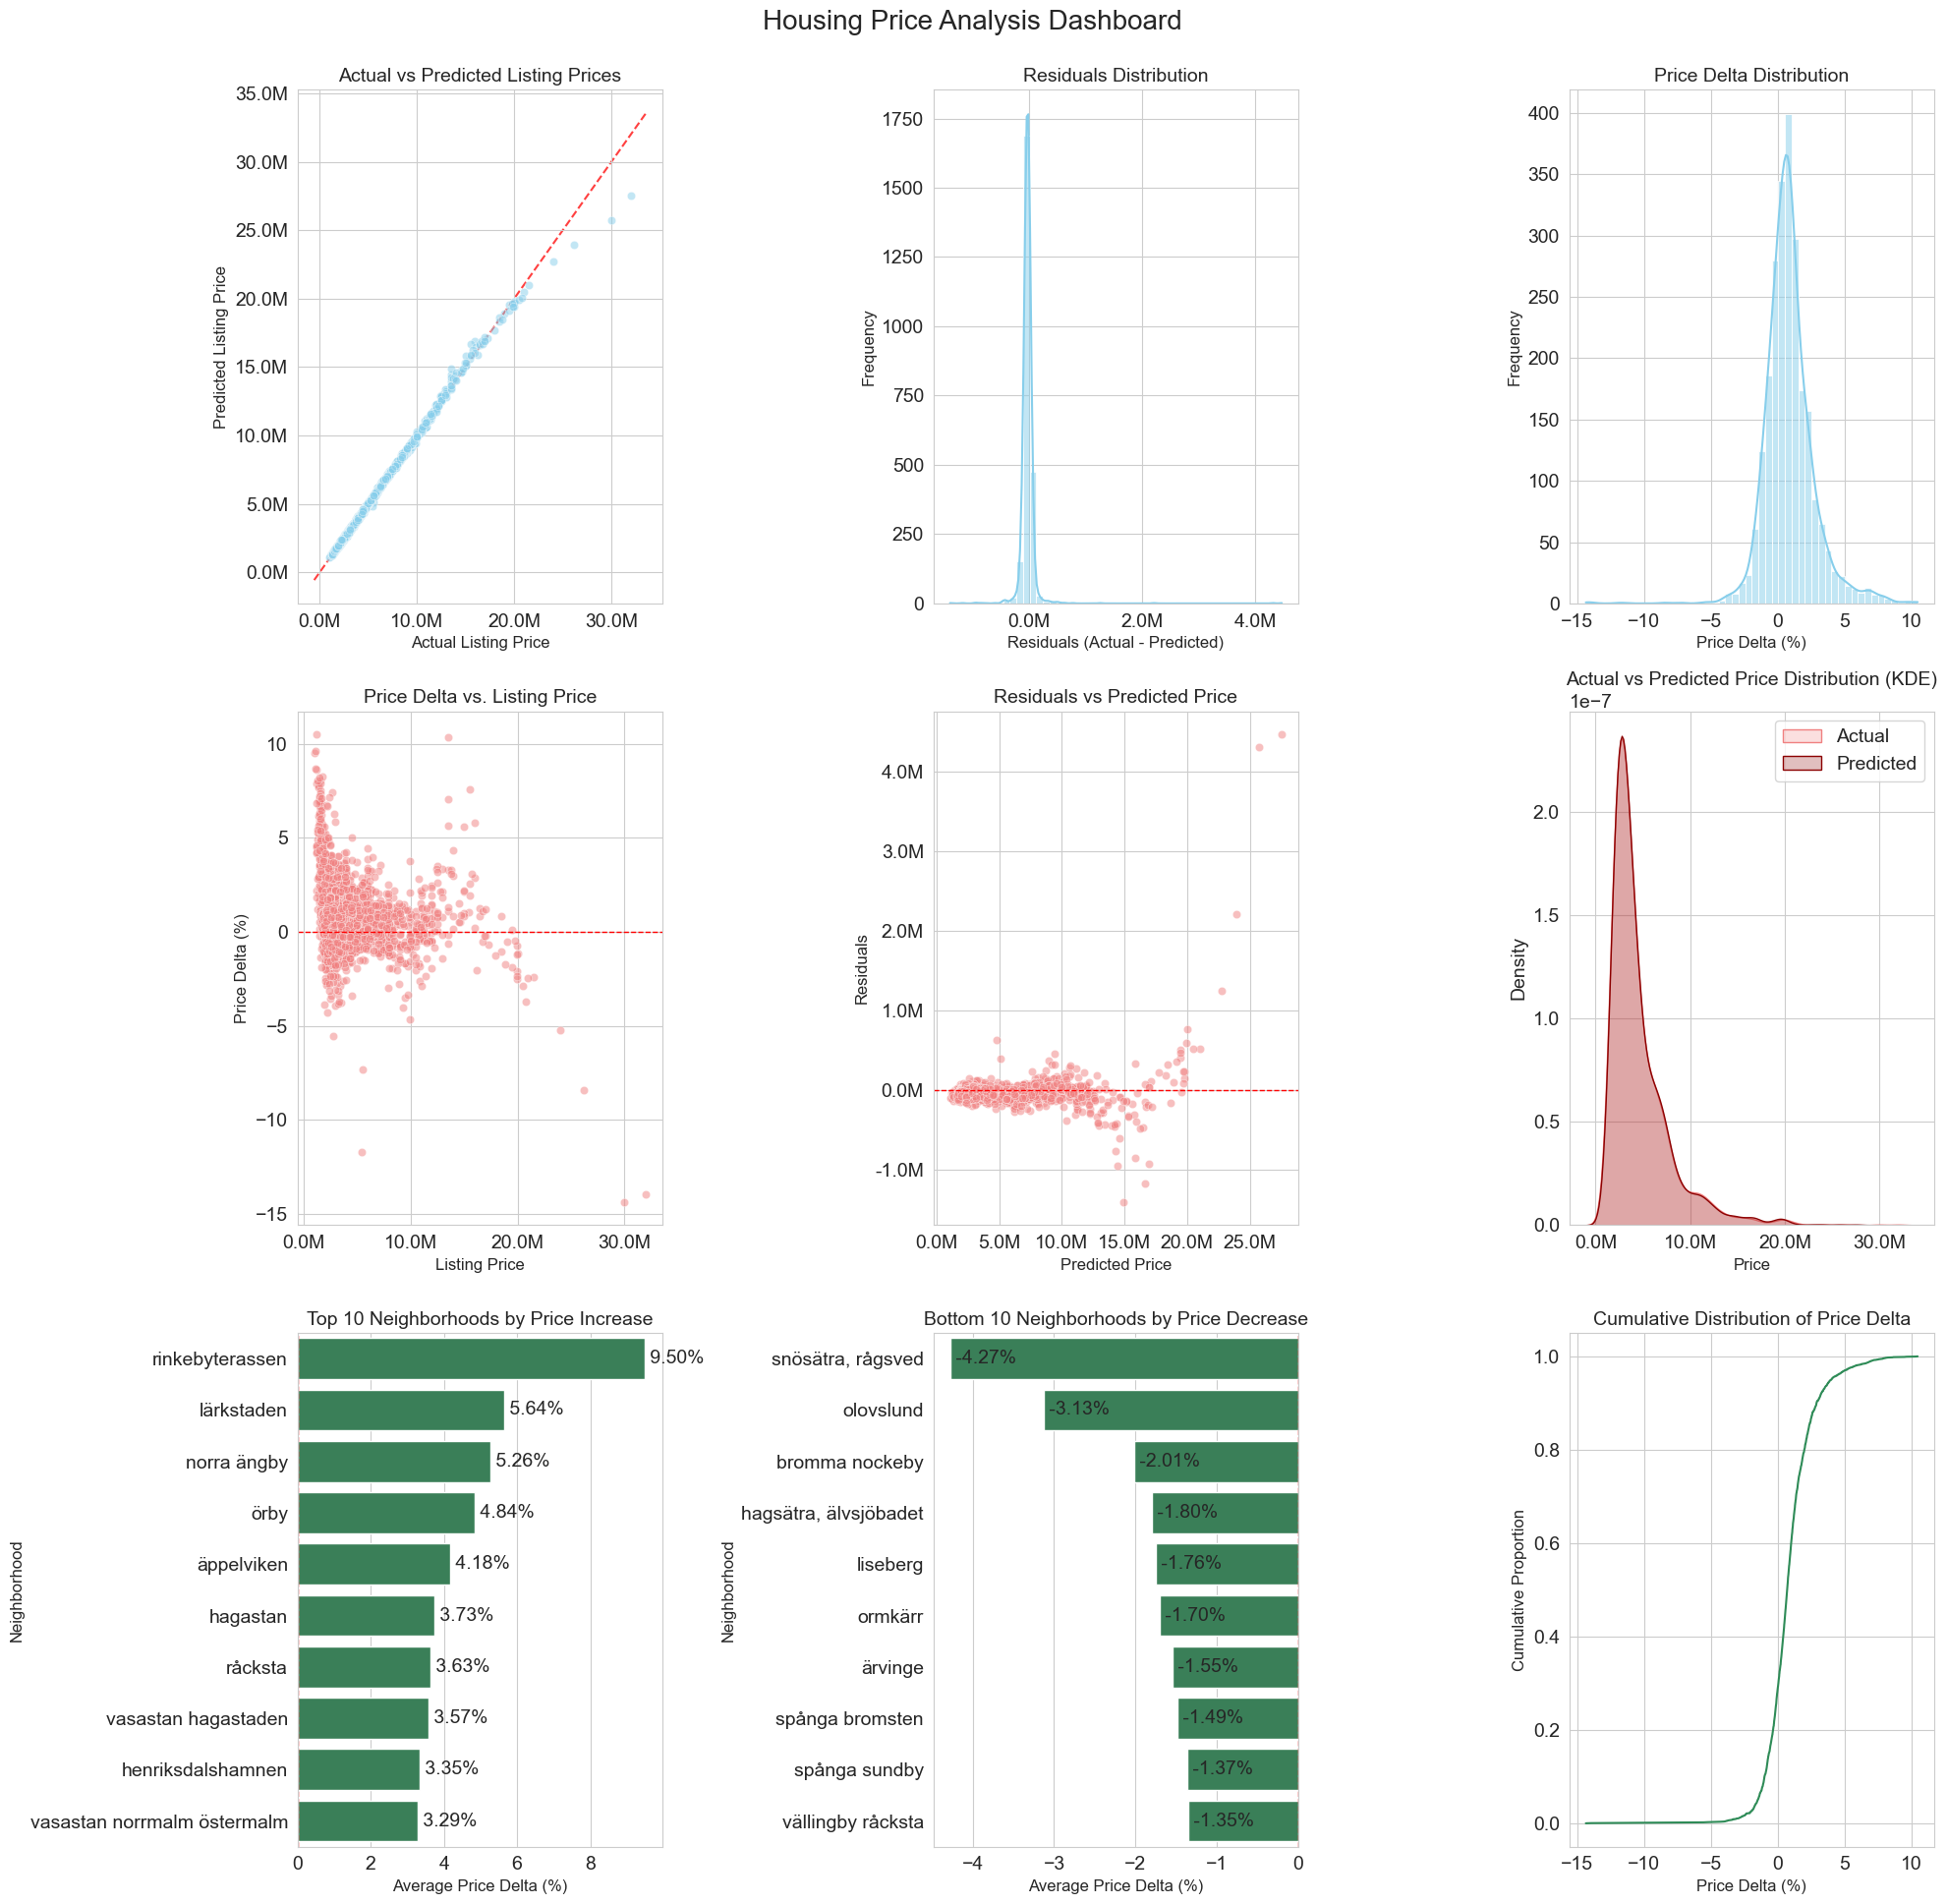

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the color scheme
colors = ['skyblue', 'lightcoral', 'seagreen']

fig, axs = plt.subplots(3, 3, figsize=(20, 19))

# Function to format axis labels in millions
def millions_formatter(x, pos):
    return f'{x/1e6:.1f}M'

# 1. Scatter Plot: Actual vs Predicted Prices
sns.scatterplot(x='listing_price', y='predicted_price', data=df_listings, alpha=0.5, color=colors[0], ax=axs[0, 0])
lims = [
    np.min([axs[0, 0].get_xlim(), axs[0, 0].get_ylim()]),
    np.max([axs[0, 0].get_xlim(), axs[0, 0].get_ylim()]),
]
axs[0, 0].plot(lims, lims, 'r--', alpha=0.75, zorder=0)
axs[0, 0].set_title('Actual vs Predicted Listing Prices', fontsize=14)
axs[0, 0].set_xlabel('Actual Listing Price', fontsize=12)
axs[0, 0].set_ylabel('Predicted Listing Price', fontsize=12)
axs[0, 0].xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
axs[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# 2. Residuals Distribution
df_listings['residuals'] = df_listings['listing_price'] - df_listings['predicted_price']
sns.histplot(df_listings['residuals'], bins=50, color=colors[0], kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Residuals Distribution', fontsize=14)
axs[0, 1].set_xlabel('Residuals (Actual - Predicted)', fontsize=12)
axs[0, 1].set_ylabel('Frequency', fontsize=12)
axs[0, 1].xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# 3. Price Delta Distribution
sns.histplot(df_listings['price_delta'], bins=50, color=colors[0], kde=True, ax=axs[0, 2])
axs[0, 2].set_title('Price Delta Distribution', fontsize=14)
axs[0, 2].set_xlabel('Price Delta (%)', fontsize=12)
axs[0, 2].set_ylabel('Frequency', fontsize=12)

# 4. Price Delta vs. Listing Price
sns.scatterplot(x='listing_price', y='price_delta', data=df_listings, alpha=0.5, color=colors[1], ax=axs[1, 0])
axs[1, 0].axhline(0, color='red', linestyle='--', lw=1)
axs[1, 0].set_title('Price Delta vs. Listing Price', fontsize=14)
axs[1, 0].set_xlabel('Listing Price', fontsize=12)
axs[1, 0].set_ylabel('Price Delta (%)', fontsize=12)
axs[1, 0].xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# 5. Residuals vs Predicted Price
sns.scatterplot(x='predicted_price', y='residuals', data=df_listings, alpha=0.5, color=colors[1], ax=axs[1, 1])
axs[1, 1].axhline(0, color='red', linestyle='--', lw=1)
axs[1, 1].set_title('Residuals vs Predicted Price', fontsize=14)
axs[1, 1].set_xlabel('Predicted Price', fontsize=12)
axs[1, 1].set_ylabel('Residuals', fontsize=12)
axs[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
axs[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))

# 6. KDE: Actual vs Predicted Price Distribution
sns.kdeplot(data=df_listings['listing_price'], color=colors[1], shade=True, label='Actual', ax=axs[1, 2])
sns.kdeplot(data=df_listings['predicted_price'], color='darkred', shade=True, label='Predicted', ax=axs[1, 2])
axs[1, 2].set_title('Actual vs Predicted Price Distribution (KDE)', fontsize=14)
axs[1, 2].set_xlabel('Price', fontsize=12)
axs[1, 2].xaxis.set_major_formatter(plt.FuncFormatter(millions_formatter))
axs[1, 2].legend()

# 7. Price Delta by Neighborhood (Top 10)
df_listings_top = df_listings.groupby('main_neighborhood')['price_delta'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=df_listings_top.values, y=df_listings_top.index, ax=axs[2, 0], color=colors[2])
axs[2, 0].set_title('Top 10 Neighborhoods by Price Increase', fontsize=14)
axs[2, 0].set_xlabel('Average Price Delta (%)', fontsize=12)
axs[2, 0].set_ylabel('Neighborhood', fontsize=12)
axs[2, 0].axvline(0, color='red', linestyle='--', linewidth=1)
for i, v in enumerate(df_listings_top):
    axs[2, 0].text(v, i, f' {v:.2f}%', va='center')

# 8. Price Delta by Neighborhood (Bottom 10)
df_listings_bottom = df_listings.groupby('main_neighborhood')['price_delta'].mean().sort_values(ascending=True).head(10)
sns.barplot(x=df_listings_bottom.values, y=df_listings_bottom.index, ax=axs[2, 1], color=colors[2])
axs[2, 1].set_title('Bottom 10 Neighborhoods by Price Decrease', fontsize=14)
axs[2, 1].set_xlabel('Average Price Delta (%)', fontsize=12)
axs[2, 1].set_ylabel('Neighborhood', fontsize=12)
axs[2, 1].axvline(0, color='red', linestyle='--', linewidth=1)
for i, v in enumerate(df_listings_bottom):
    axs[2, 1].text(v, i, f' {v:.2f}%', va='center')

# 9. Cumulative Distribution of Price Delta (unchanged)
df_listings['price_delta'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_listings['price_delta'].dropna(inplace=True)
sorted_delta = np.sort(df_listings['price_delta'])
cum_dist = np.arange(len(sorted_delta)) / float(len(sorted_delta))
axs[2, 2].plot(sorted_delta, cum_dist, color=colors[2])
axs[2, 2].set_title('Cumulative Distribution of Price Delta', fontsize=14)
axs[2, 2].set_xlabel('Price Delta (%)', fontsize=12)
axs[2, 2].set_ylabel('Cumulative Proportion', fontsize=12)

# Adjust layout and add a main title
plt.tight_layout()
fig.suptitle('Housing Price Analysis Dashboard', fontsize=20, y=1.02)
plt.show()

### Feature Importance

In [209]:
import sklearn

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Numeric feature names (excluding 'listing_price' which is handled separately)
numeric_feature_names = numeric_features.copy()
numeric_feature_names.remove('listing_price')  # Remove 'listing_price' as it's handled separately

# Get OneHotEncoder from the categorical pipeline
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']

# Get categorical feature names after one-hot encoding
categorical_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names
feature_names_main = numeric_feature_names + list(categorical_feature_names)
print("Total number of features after preprocessing (excluding 'listing_price'):", len(feature_names_main))

# Combine numeric and categorical feature names
feature_names_main = numeric_feature_names + list(categorical_feature_names)
print("Total number of features after preprocessing (excluding 'listing_price'):", len(feature_names_main))

# Initialize the mapping dictionary
feature_to_indices = {}

# Map numeric features
for idx, feature_name in enumerate(numeric_feature_names):
    feature_to_indices[feature_name] = [idx]

# Map categorical features
start_idx = len(numeric_feature_names)
for feature_name, categories in zip(categorical_features, ohe.categories_):
    num_categories = len(categories)
    indices = list(range(start_idx, start_idx + num_categories))
    feature_to_indices[feature_name] = indices
    start_idx += num_categories

# Handle 'listing_price' separately
feature_to_indices['listing_price'] = 'listing_price'  # We'll handle this separately


Total number of features after preprocessing (excluding 'listing_price'): 217
Total number of features after preprocessing (excluding 'listing_price'): 217


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
Baseline RMSE: 103111.3906
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
Feature: size, Importance (increase in RMSE): 732253.3151
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step
Feature: rooms, Importance (increase in RMSE): 1229698.9690
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
Feature: monthly_fee, Importance (increase in RMSE): 4537.8835
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
Feature: rooms_per_sqm, Importance (increase in RMSE): 337982.0670
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step
Feature: price_per_sqm, Importance (increase in RMSE): 523946.1801
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
Feature: months_since_sale, Importance (increase in RMSE): 7786.6808
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
Feature: log_size, Importance (increase in RMSE): 890697.6406
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
Feature: log_price_per_sqm, Importance (increase in RMSE): 1092587.8938
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
Feat

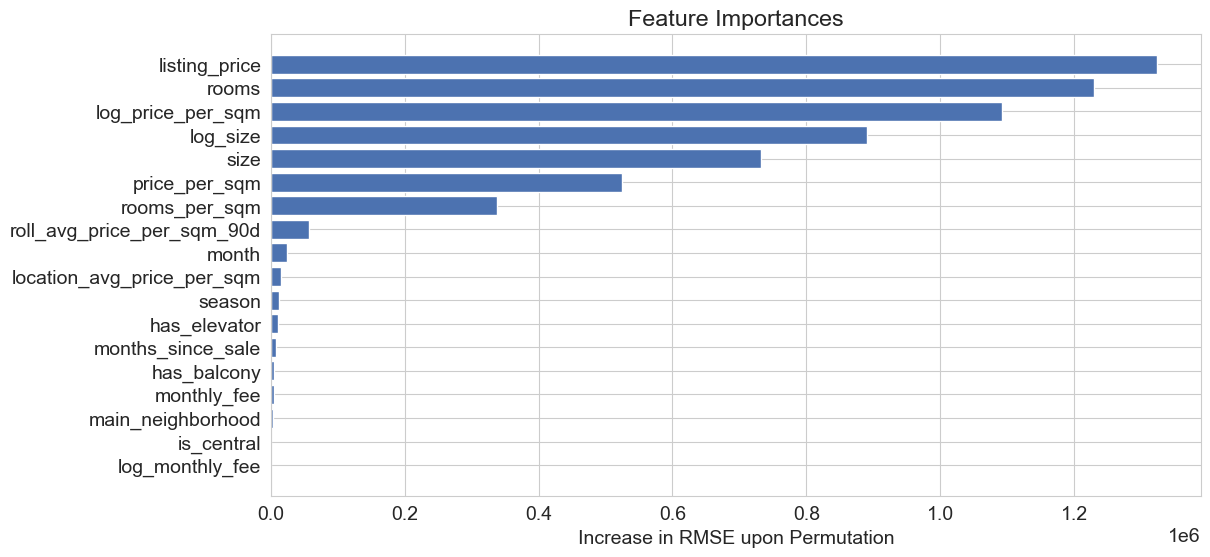

In [210]:
def permutation_importance(model, X_val_main, X_val_listing_price, y_val_scaled, y_scaler, feature_to_indices, baseline_rmse):
    import copy
    feature_importances = {}
    
    # Get baseline predictions
    y_val_pred_scaled = model.predict([X_val_main, X_val_listing_price]).flatten()
    y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
    y_val_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1,1)).flatten()
    
    # Calculate baseline performance
    mse = mean_squared_error(y_val_true, y_val_pred)
    baseline_rmse = np.sqrt(mse)
    
    for feature_name, indices in feature_to_indices.items():
        # Copy validation data
        X_val_main_permuted = X_val_main.copy()
        X_val_listing_price_permuted = X_val_listing_price.copy()
        
        if feature_name == 'listing_price':
            # Permute 'listing_price'
            X_val_listing_price_permuted[:, 0] = np.random.permutation(X_val_listing_price_permuted[:, 0])
        else:
            # Permute the feature in X_val_main
            X_val_main_permuted[:, indices] = np.random.permutation(X_val_main_permuted[:, indices])
        
        # Predict with permuted data
        y_val_pred_scaled = model.predict([X_val_main_permuted, X_val_listing_price_permuted]).flatten()
        y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
        
        # Compute performance metric
        mse = mean_squared_error(y_val_true, y_val_pred)
        rmse = np.sqrt(mse)
        
        # Compute importance as the increase in RMSE
        importance = rmse - baseline_rmse
        feature_importances[feature_name] = importance
        print(f"Feature: {feature_name}, Importance (increase in RMSE): {importance:.4f}")
    
    return feature_importances

# Compute baseline RMSE
y_val_pred_scaled = nn_model.predict([X_val_main, X_val_listing_price]).flatten()
y_val_pred = y_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
y_val_true = y_scaler.inverse_transform(y_val_scaled.reshape(-1,1)).flatten()

baseline_mse = mean_squared_error(y_val_true, y_val_pred)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline RMSE: {baseline_rmse:.4f}")

# Run permutation importance
feature_importances = permutation_importance(
    nn_model, 
    X_val_main, 
    X_val_listing_price, 
    y_val_scaled, 
    y_scaler, 
    feature_to_indices, 
    baseline_rmse
)

# Sort features by importance
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

# Convert to DataFrame for easier plotting
importance_df = pd.DataFrame(sorted_importances, columns=['Feature', 'Importance'])

# Plotting
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Increase in RMSE upon Permutation')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()
